In [15]:
import numpy as np
import os
import json
from glob import glob
import random
import collections
import math
import cv2
from skimage import measure
import time
from PIL import Image
import imutils
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [169]:
def read_img(path, resize_ratio, is_gray=True):
    assert os.path.exists(path), path
    if is_gray:
        img = cv2.imread(path, 0)
    else:
        print('Read image:', path)
        img = cv2.imread(path)
    img = cv2.resize(img, (0, 0), fx=resize_ratio, fy=resize_ratio)
    return img

def read_inp(path, resize_ratio=.3):
    if os.path.isdir(path):
        path_line = os.path.join(path, 'refine_line.png')
        path_dot = os.path.join(path, 'output2.png')
        path_inp = os.path.join(path, 'input.png')
        img_inp = read_img(path_inp, args.resize_ratio, is_gray=False)
        line = read_img(path_line, args.resize_ratio)  
    else:
        img = read_img(path, resize_ratio, is_gray=False)
        w = img.shape[1]
        img_inp = img[:, :w//2]
        line = img[:, w//2:, -1]
        
    return img_inp, line
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))

    return (cnts, boundingBoxes)

def show(img, fz=20):
    plt.figure(figsize=(fz, fz))
    plt.imshow(img)
    plt.show()
    
def cell_cut(img_inp, line, close_h=3, close_w=3, resize_ratio=1):
    rt_cells = []
    img_inp = cv2.resize(img_inp, (0, 0), fx=resize_ratio,fy=resize_ratio)
    line = cv2.resize(line, (0, 0), fx=resize_ratio,fy=resize_ratio)
    def auto_canny(image, sigma=0.33):
        v = np.median(image)
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        edged = cv2.Canny(image, lower, upper)
        return edged
    
    def get_contour(edges):
        labels = measure.label(edges, neighbors=8, background=0)
        cnts = []
        for i, label in enumerate(np.unique(labels)):
            # if this is the background label, ignore it
            if label == 0:
                continue
            # otherwise, construct the label mask and count the
            # number of pixels
            labelMask = np.zeros([*edges.shape, 3], dtype="uint8")
            lm = np.zeros_like(edges, dtype='uint8')
            labelMask[labels == label] = (255, 0, 0) if i % 2 == 0 else (0, 0, 255)
            lm[labels == label] = 255
            numPixels = cv2.countNonZero(
                cv2.cvtColor(labelMask, cv2.COLOR_RGB2GRAY))
            coords = np.column_stack(np.where(lm > 0))
            coords = np.column_stack([coords[:, 1], coords[:, 0]])

            arc = cv2.arcLength(coords, False)
            x, y, w, h = cv2.boundingRect(coords)
            cnts.append(coords)

        cnts = sort_contours(cnts, 'left-to-right')[0]
        cnts = sort_contours(cnts,'top-to-bottom')[0]

        return cnts

    close = cv2.morphologyEx(line, cv2.MORPH_CLOSE, np.ones([close_h, close_w]))
    thresh = cv2.threshold(close, 50, 300, cv2.THRESH_BINARY)[-1]
    edges = auto_canny(thresh)
    cnts = get_contour(edges)
    i = 0
    mask = img_inp.copy()
    for coords in cnts:
        x,y,w,h = cv2.boundingRect(coords)
        is_convex = cv2.isContourConvex(coords)
        rect = cv2.minAreaRect(coords)
        angle = rect[-1]
        if angle < -45:
            angle = -(90 + angle)
            
        area = cv2.contourArea(coords)
        
        if   h < 100 and h> 5:
            rect = cv2.minAreaRect(coords)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            color = (255,0,0) if i % 2 == 0 else (0,255,255)
            cv2.drawContours(mask,[box],0,color, 1)
            rt_cells.append(box)
            cX, cY = box.mean(axis=0).astype('int')
    return mask, rt_cells

In [150]:
def get_tensor_by_name(name):
    name_on_device = '{}:0'.format(name)
    return tf.get_default_graph().get_tensor_by_name(name_on_device)


def run(feed_image, checkpoint, batch_size=8):
    meta_path = os.path.join(checkpoint, 'export.meta')
    print('meta path:', meta_path)
    assert os.path.exists(meta_path), meta_path+' does not exist'
    tf.train.import_meta_graph(meta_path)
    
    inputs = get_tensor_by_name('inputs')
    outputs = get_tensor_by_name('outputs')
    batch_input_tensor = get_tensor_by_name('batch_input_tensor')
    batch_input_placeholder = get_tensor_by_name('batch_input_placeholder')
    batch_output_tensor = get_tensor_by_name('batch_output_tensor')
    batch_output_placeholder = get_tensor_by_name('batch_output_placeholder')
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(checkpoint))
        batch_input = sess.run(batch_input_tensor, {inputs:feed_image})
        rv = []

        for i in range(0, len(batch_input), batch_size):
            print('\r {:0.2f} %'.format(i/len(batch_input)), end='')
            rv.append(sess.run(batch_output_tensor, {batch_input_placeholder: batch_input[i:i+batch_size]}))
        output_feed = np.concatenate(rv, axis=0)
        rv = sess.run(outputs, {batch_output_placeholder: output_feed, inputs:feed_image})
    return rv

# GENERAL MODEL

In [151]:
%%time
tf.reset_default_graph()
down_scale = 1

checkpoint = '../frozen_model/shalow_3_pros/'
raw_path = '../data/bpr/raw/2/IMG_9263.png'
raw_image = read_img(raw_path, down_scale, is_gray=False)
print('raw_image: ', raw_image.shape)
output_image = run(raw_image, checkpoint, batch_size=32)

Read image: ../data/bpr/raw/2/IMG_9263.png
raw_image:  (2448, 3264, 3)
meta path: ../frozen_model/shalow_3_pros/export.meta
INFO:tensorflow:Restoring parameters from ../frozen_model/shalow_3_pros/export
 0.91 %CPU times: user 6.06 s, sys: 1.36 s, total: 7.42 s
Wall time: 6.99 s


In [170]:
%%time
cell_cut_resize_ratio = .5
cell_cut_output, cells = cell_cut(raw_image, output_image[...,0], resize_ratio=cell_cut_resize_ratio)

CPU times: user 3.87 s, sys: 0 ns, total: 3.87 s
Wall time: 3.14 s


In [175]:
print('num of cells:', len(cells), '\ncell_0:\n', cells[0])

num of cells: 109 
cell_0:
 [[162  18]
 [137   0]
 [144  -9]
 [169   9]]


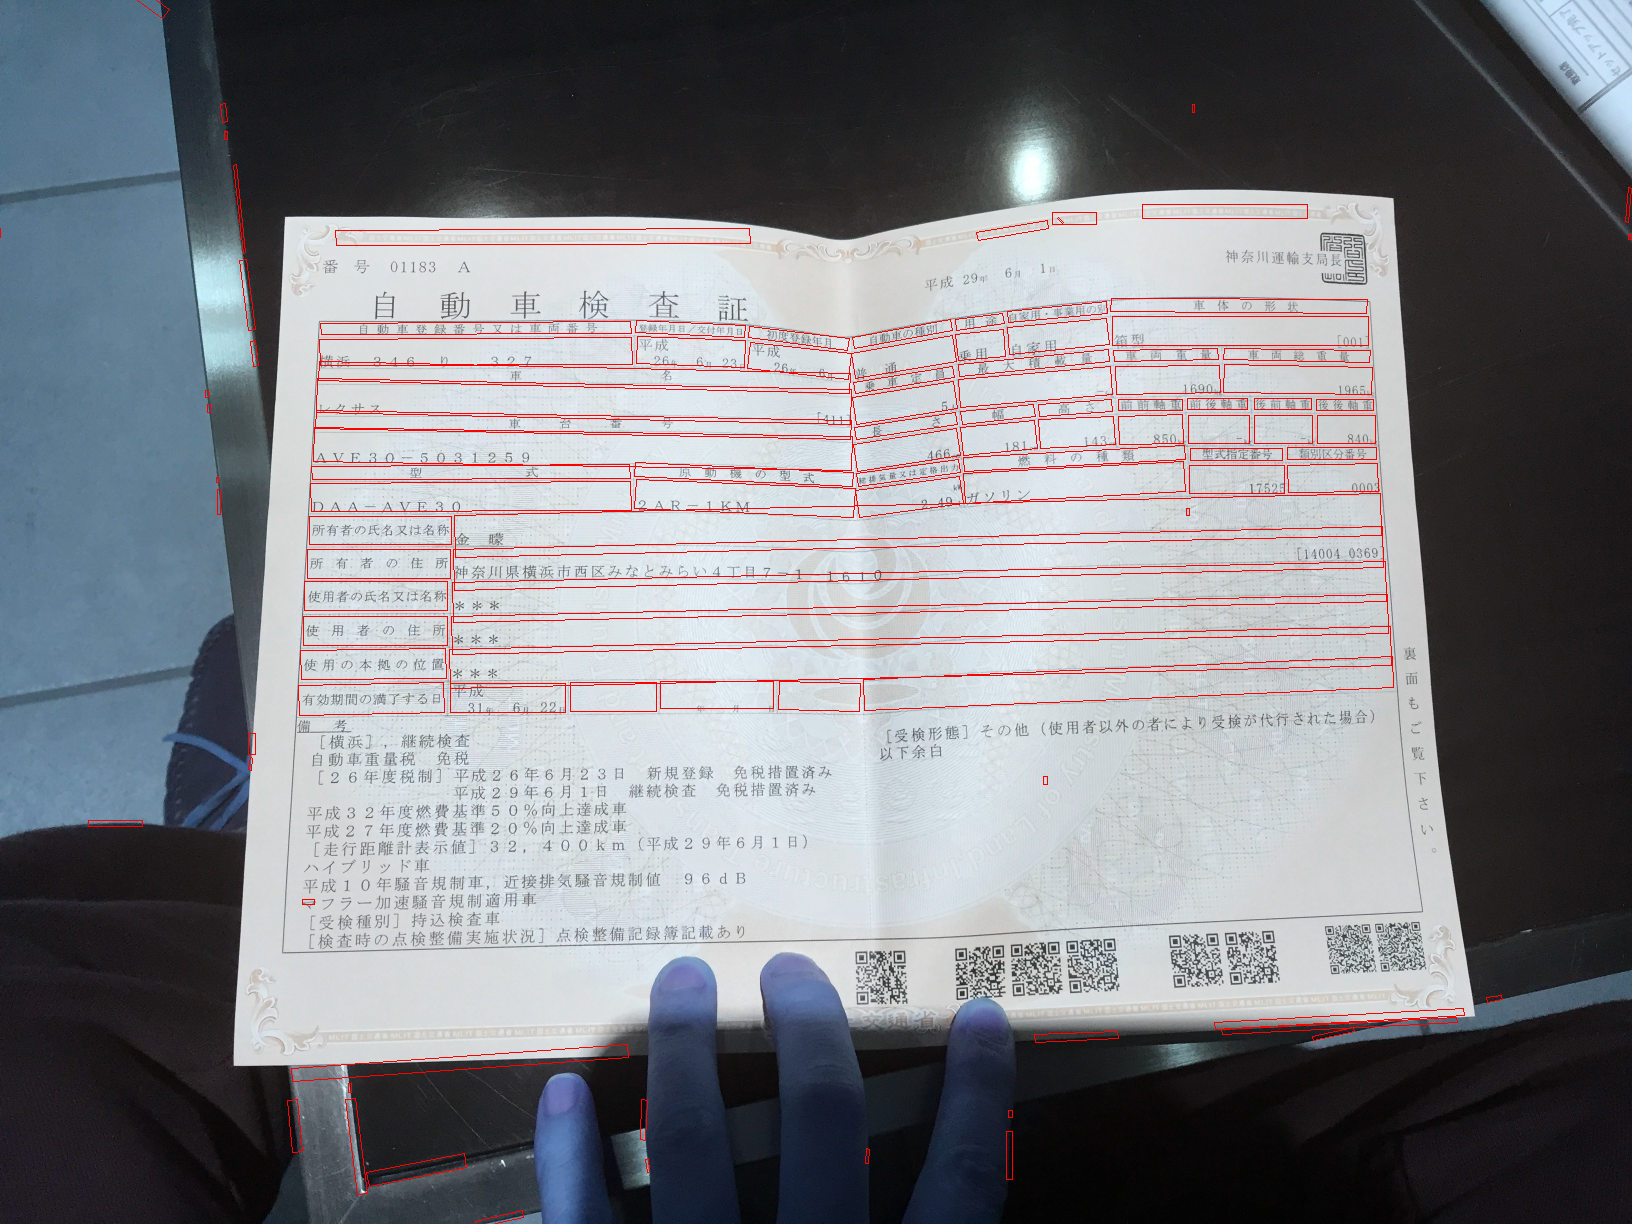

In [168]:
Image.fromarray(cell_cut_output)

# BPROST MODEL

In [176]:
%%time
tf.reset_default_graph()
down_scale = .5
checkpoint = '../frozen_model/bpr1/'
raw_path = '../data/bpr/raw/1/1.png'
raw_image = read_img(raw_path, down_scale, is_gray=False)
print('raw_image: ', raw_image.shape)
output_image = run(raw_image, checkpoint, batch_size=32)

Read image: ../data/bpr/raw/1/1.png
raw_image:  (1544, 2744, 3)
meta path: ../frozen_model/bpr1/export.meta
INFO:tensorflow:Restoring parameters from ../frozen_model/bpr1/export
 0.53 %CPU times: user 5.95 s, sys: 1.89 s, total: 7.84 s
Wall time: 7.57 s


In [177]:
cell_cut_resize_ratio = .5
cell_cut_output = cell_cut(raw_image, output_image[...,0], resize_ratio=cell_cut_resize_ratio)
Image.fromarray(cell_cut_output)

AttributeError: 'tuple' object has no attribute '__array_interface__'